In [19]:
'''
This notebook implements a batch run for OFAT analysis
Packages
'''
from model import *
import csv
from mesa.batchrunner import BatchRunner
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol

In [15]:
'''
Initial Conditions as given in notebook
'''
initial_houses = 20
initial_households = 30
rental_cost = 1000
savings_lower = 0
savings_upper = 50_000
price_lower = 10_000
price_upper = 100_000

'''
This defines model run
'''
samples = 10
max_steps = 2
ofat_size = 5

In [16]:
'''
This defines the bounds of for the ofat analysis
'''
problem = {
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 'rental_cost'],
    'bounds': [[1, 40_000], [1, 100_000], [10_000, 90_000], [11_000, 100_000], [1000, 20_000]]    
}

In [17]:
'''
This defines the batch run
'''
df_experiment = pd.DataFrame(columns = ('Variable', 'Parameter', 'Gini'))

for i, var in tqdm.tqdm(enumerate(problem['names'])):
    '''
    Iterate over parameters as defined in problem
    '''
    parameter = var
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    
    for j in variable_values:
        '''
        Iterate over bounds of paramter
        '''
                    
        for k in range(samples):
            '''
            Repeat trial with certain parameter k times to apply clt
            '''            
            model = HousingMarket(parameter := int(j))
            model.run_model(max_steps)
            data = model.datacollector.get_model_vars_dataframe()
            
            dict = {'Variable': var, 'Parameter': j, 'Gini': data['Gini'].iloc[-1]}
            df_experiment = df_experiment.append(dict, ignore_index=True)

'''
Save result to Panda's dataframe
'''
            
experiment_raw = df_experiment
experiment_raw = df_experiment.set_index(['Variable', 'Parameter'])

5it [03:19, 39.86s/it]


C:\Users\sebas\AppData\Local\Temp/ipykernel_16796/2669713795.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  y.append(experiment_raw.loc[var, j].mean()[0])
C:\Users\sebas\AppData\Local\Temp/ipykernel_16796/2669713795.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  err.append(1.96 * experiment_raw.loc[var, j].std()[0] / np.sqrt(samples))
C:\Users\sebas\AppData\Local\Temp/ipykernel_16796/2669713795.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  y.append(experiment_raw.loc[var, j].mean()[0])
C:\Users\sebas\AppData\Local\Temp/ipykernel_16796/2669713795.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  err.append(1.96 * experiment_raw.loc[var, j].std()[0] / np.sqrt(samples))
C:\Users\sebas\AppData\Local\Temp/ipykernel_16796/2669713795.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  y.append(experiment_raw.loc[var, j].mean()[0])
C

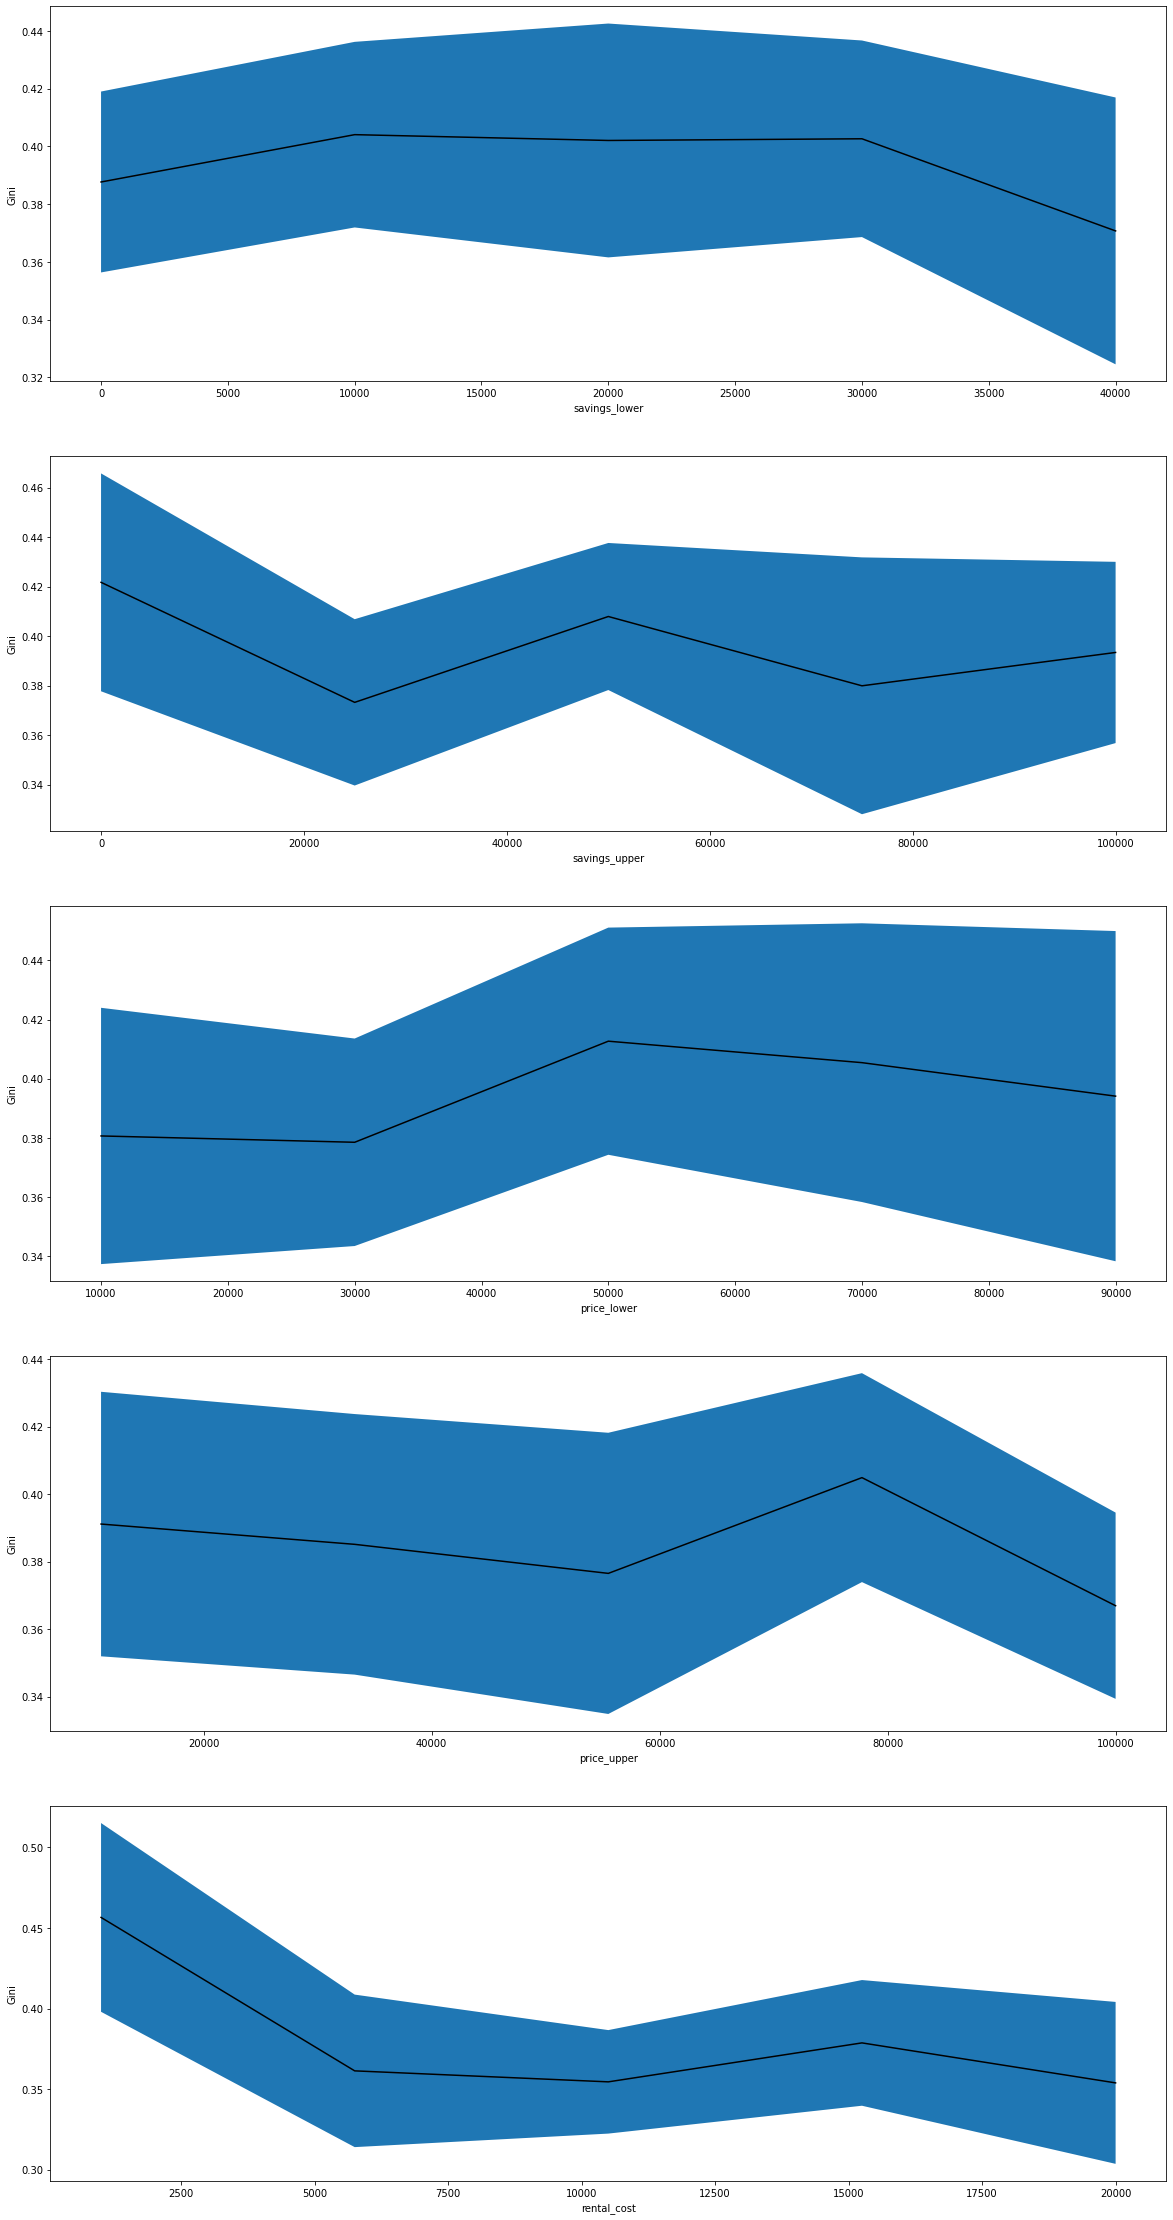

In [18]:
# Data
fig, axs = plt.subplots(len(problem['names']), figsize = (20,40))

for i, var in enumerate(problem['names']):
    
    y = []
    err = []
    
    parameter = var
    x = np.linspace(*problem['bounds'][i], ofat_size)

    
    for j in x:
        y.append(experiment_raw.loc[var, j].mean()[0])
        err.append(1.96 * experiment_raw.loc[var, j].std()[0] / np.sqrt(samples))
    
    axs[i].plot(x, y, c = 'k')
    axs[i].fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err)) 
    axs[i].set_ylabel("Gini")
    axs[i].set_xlabel(var)

In [22]:
'''
This section runs Sobol
'''


problem = {
    'num_vars': 5,
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 'rental_cost'],
    'bounds': [[1, 40_000], [1, 100_000], [10_000, 90_000], [11_000, 100_000], [1000, 20_000]]    
}

In [31]:
param_values = saltelli.sample(problem, 4)
print(param_values)

[[ 3750.90625 46875.53125 47500.      69406.25     6343.75   ]
 [38750.03125 46875.53125 47500.      69406.25     6343.75   ]
 [ 3750.90625 53125.46875 47500.      69406.25     6343.75   ]
 [ 3750.90625 46875.53125 77500.      69406.25     6343.75   ]
 [ 3750.90625 46875.53125 47500.      52718.75     6343.75   ]
 [ 3750.90625 46875.53125 47500.      69406.25     3968.75   ]
 [ 3750.90625 53125.46875 77500.      52718.75     3968.75   ]
 [38750.03125 46875.53125 77500.      52718.75     3968.75   ]
 [38750.03125 53125.46875 47500.      52718.75     3968.75   ]
 [38750.03125 53125.46875 77500.      69406.25     3968.75   ]
 [38750.03125 53125.46875 77500.      52718.75     6343.75   ]
 [38750.03125 53125.46875 77500.      52718.75     3968.75   ]
 [23750.40625 96875.03125 87500.      24906.25    15843.75   ]
 [18750.53125 96875.03125 87500.      24906.25    15843.75   ]
 [23750.40625  3125.96875 87500.      24906.25    15843.75   ]
 [23750.40625 96875.03125 37500.      24906.25    15843

In [34]:
for i in range(4):
    for vals in param_values:
        
        model = HousingMarket(savings_lower = int(vals[0]), savings_upper = int(vals[1]),
                              price_lower = int(vals[2]), price_upper = int(vals[3]),
                             rental_cost = int(vals[4]))
        
        model.run_model(3)
        data = model.datacollector.get_model_vars_dataframe()       

ValueError: empty range for randrange() (77500, 69407, -8093)